In [3]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt

# import tensorflow as tf
from time import time
import pandas as pd


from Jet_Observables import NSubJettiness, Thrust, Uniform, Disk, Ellipse, Point, NStructure
from src.Observables import CustomObservable

from src.utils.plot_utils import load_data, plot, plot_event, make_gif, timer_func
from utils import load_dataset

(100000, 200, 3)
171.3041547490139
158.96944759658837
161.67095907881824
217.78488504165702
157.17390244406099
145.22444003640751
210.3551181009588
177.416412594453
162.74268936127768
163.63839296713152
170.35772451014682
184.45026946055603
141.46044830239734
175.44680257039676
184.9265753025777
162.44452614319133
148.96208679598263
165.3719959420928
188.7614233069914
196.7868393728866
159.86238375976637
141.60346829335782
156.75980806178313
186.42473543820887
176.39720193373475
176.03338521086624
206.6853289996457
226.9855612421937
197.07723694642704
199.08925695723778
194.0266898512877
222.23395711059644
189.0792295872403
194.60080615249285
153.2238866400151
184.61169123509328
181.16802515647495
177.3622155966618
176.75794803366585
169.78131491732745
164.9862075446309
160.16636299640768
181.1016390817129
167.86577297005732
156.94081366823715
216.71348479040947
183.8286682877175
137.17977943973528
209.4085693057201
159.55066688848103
172.14339426682807
188.02698490468092
175.928294251

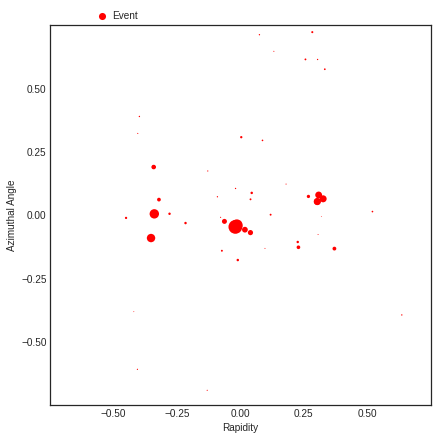

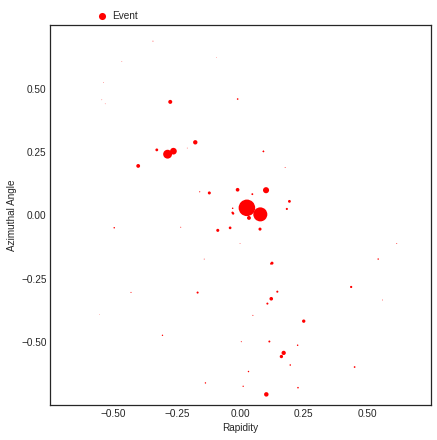

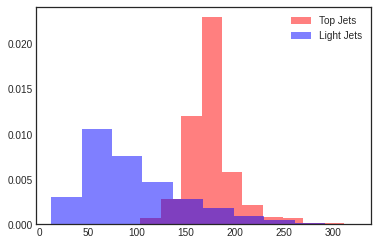

In [4]:
# Parameters
R = 0.5
beta = 1.0
N = 1000
epochs = 75
mass_lower = 145
mass_upper = 205
eta_cut = 1.3
plot_dir = "results"



signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]


# Example plots
example_signal = signal[0]
plot_event(example_signal[0], example_signal[1], R, color = "red")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

plt.hist(signal_masses, color = "red", alpha = 0.5, label = "Top Jets", density = True)
plt.hist(background_masses, color = "blue", alpha = 0.5, label = "Light Jets", density = True)
plt.legend()


In [5]:
_1subjettiness = NStructure(Point, N = 1, name = "1-Subjettiness", initializer = "kt", R = R, beta = beta)
_2subjettiness = NStructure(Point, N = 2, name = "2-Subjettiness", initializer = "kt", R = R, beta = beta)
_3subjettiness = NStructure(Point, N = 3, name = "3-Subjettiness", initializer = "kt", R = R, beta = beta)

observables = [
              _1subjettiness, _2subjettiness, _3subjettiness,
               #    _thrust, 
            #    _3diskiness_plus_pileup,
            #    _isotropy,
               # _3ellipsiness,
               # _1ellipsiness_plus_pileup
               ]

# training_config_dict = {"epochs" : 500,
#                         "optimizer" : tf.keras.optimizers.Adam(lr = 0.05),
#                         "verbose" : False,
#                         "early_stop" : 25,
#                         "resample" : True,
#                         "z_schedule": 0.1}

In [6]:
emds_old = np.zeros(shape = (len(events),len(observables), N))
times_old = np.zeros(shape = (len(events),len(observables), N))

# # Calculate the EMDs for each observable, for each event
# for (i, event_type) in enumerate(events):
#     for (j, obs) in enumerate(observables):
#         for (k, event) in enumerate(events[i]):

#             t1 = time()
#             params = obs.calculate(event, training_config_dict)
#             emds_old[i,j,k] = params["EMD"]
#             t2 = time()
#             times_old[i,j,k] = t2 - t1

#             print("Event %d" %k, "Obs: %s" % obs.name, "Class: %s" % event_labels[i], "Value: %.3f" % params["EMD"], "Finished in %.3fs" % (t2 - t1))

# print(np.sum(times_old))

# df = pd.DataFrame(emds_old)
# df.to_csv("emds_old.csv")
# df = pd.DataFrame(times_old)
# df.to_csv("times_old.csv")

## Sinkhorn

In [7]:
import torch
from torch.autograd import grad
from torch import optim
from geomloss import SamplesLoss
from pyjet import cluster

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [8]:
class CoolPoint(object):

    def __init__(self, mean, z, N = 1):

        self.center = torch.tensor(mean)
        self.z = torch.tensor(z)
        self.N = N

        self.parameters = [self.center]

        self.t = self.sample(self.N)

        self.name = "Point"

    def initialize(self, event, R):
        self.center = torch.tensor(event[0], dtype = torch.float)
        self.z = torch.tensor(event[1], dtype = torch.float)
        self.parameters = [self.center]

    def sample(self,N):
        return self.center.reshape((1,-1))

    def get_event(self):
        self.t = self.sample(self.N)
        return (self.center.reshape(1,-1), self.z * torch.ones((self.N,)) / self.N)


    def get_zs(self):
        return self.get_event()[1].detach().numpy()

    def get_points(self):
        return self.get_event()[0].detach().numpy()

    def get_param_dict(self, loss):

        dict = {"EMD" : loss}
        dict["Center"] = self.center.clone().detach().numpy()
        dict["z"] = self.z.clone().detach().numpy()
        return dict

    def draw(self,ax):
        pass

    def print(self):
        pass

    def __str__(self):
        return "z: %.3f GeV" % (self.z.data)

class MixtureModel(object):

    def __init__(self, shapes = None):

        self.shapes = shapes
        self.ids = range(len(shapes))
        self.zs = [shape.z for shape in self.shapes]
        self.parameters = []
        for shape in shapes:
            self.parameters += shape.parameters
        

    def get_event(self):
        event = concatenate_events([shape.get_event() for shape in self.shapes])
        return event

    def get_zs(self):
        return self.get_event()[1]

    def get_points(self):
        return self.get_event()[0]

    def initialize(self, event, R):
        points, energies = kt_initializer(event, len(self.shapes), R)
        for (i, shape) in enumerate(self.shapes):
            shape.initialize((points[i], energies[i]),R)

        self.zs = [shape.z for shape in self.shapes]
        self.parameters = []
        for shape in self.shapes:
            self.parameters += shape.parameters


    def normalize(self):
            
        z_test = activate(torch.tensor(self.zs).reshape((1, -1)))
        for (i, shape) in enumerate(self.shapes):
            shape.z.data = z_test[0,i]
        self.zs = [shape.z for shape in self.shapes]    


    def get_param_dict(self, loss):
        dict = {"EMD" : loss}
        for (i,shape) in enumerate(self.shapes):
            dict_i = shape.get_param_dict(loss)
            for key, value in dict_i.items():
                if key != "EMD":
                    dict[key + "_%d" % self.ids[i]] = value 
        return dict


def concatenate_events(events):
    points, zs = [], []
    for event in events:
        points.append(event[0])
        zs.append(event[1])
    points = torch.cat(points, dim = 0)
    zs = torch.cat(zs, dim = 0)
    return (points, zs)


def activate(x):
    m, n = x.shape
    cnt_m = torch.arange(m, device=x.device)
    cnt_n = torch.arange(n, device=x.device)
    u = x.sort(dim=1, descending=True).values
    v = (u.cumsum(dim=1) - 1) / (cnt_n + 1)
    w = v[cnt_m, (u > v).sum(dim=1) - 1]
    return (x - w.view(m, 1)).relu()


def kt_initializer(event, N, R):

    y, z = event

    four_vectors = []
    for (y_i, z_i) in zip(y, z):
        v = (z_i, y_i[0], y_i[1], 0)
        four_vectors.append(v)
    four_vectors = np.array(four_vectors, dtype = [("pt", "f8"),("eta", "f8"),("phi", "f8"),("mass", "f8")])
    sequence = cluster(four_vectors, R=R/4, p=1)
    jets = sequence.exclusive_jets(N)

    # Apply initialization
    jets = jets[:N]
    initialization = []
    energies = []
    for jet in jets:
        initialization.append([jet.eta, jet.phi])
        energies.append(jet.pt)
    initialization = np.array(initialization).astype(np.float32)
    return initialization, energies / np.sum(energies)

In [9]:



_1point = MixtureModel(shapes = [CoolPoint((0.0,0.0), 1.0)])
_2point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.5), CoolPoint((1.0,0.0), 0.5)])
_3point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.333), CoolPoint((1.0,0.0), 0.333), CoolPoint((0.0,0,0), 0.333)])

observables = [_1point, _2point, _3point]


def train(event, observable, epochs = 500, lr = 0.05, early_stopping = 25, epsilon = 0.01, annealing = 0.99, init = True):

    count = 0
    min_loss = np.inf
    params = {}
    
    if init:
        observable.initialize(event, R)

    event_clone = (torch.tensor(event[0], dtype = torch.float32), torch.tensor(event[1], dtype = torch.float32))

    Loss = SamplesLoss("sinkhorn", p = beta, blur = epsilon**(1/beta))


    # Require grad:
    parameters = []
    for shape in observable.shapes:
        shape.sample(shape.N)
        for parameter in shape.parameters:
            parameter.requires_grad = True
            parameters.append(parameter)
        shape.z.requires_grad = True


    if len(observable.shapes) > 1:
        optimizer = optim.Adam([*parameters, *observable.zs], lr = lr)  
    else:
        optimizer = optim.Adam([*parameters,], lr = lr)  



    for i in range(epochs):
        loss = train_step(event_clone, observable, optimizer, epsilon, Loss)
        if loss < min_loss * (1 - epsilon):
            count = 0
            min_loss = loss
            params = observable.get_param_dict(min_loss)
        else:
            count += 1
        if count == early_stopping:
            break

        # lr *= annealing

    # for shape in observable.shapes:
    #     print(shape.parameters, shape.z)

    params["Epochs"] = i
    return params

def train_step(event, observable, optimizer, epsilon, Loss):


    parameters = []
    for shape in observable.shapes:
        shape.sample(shape.N)
        for parameter in shape.parameters:
            # parameter.requires_grad = True
            parameters.append(parameter)
        # shape.z.requires_grad = True


    # Create a copy of the data...
    x_i, a_i = event
    y_j, b_j = observable.get_event()

    # Compute the loss + gradients:
    
    optimizer.zero_grad()
    
    Loss_xy = Loss(a_i, x_i, b_j, y_j) / R

    Loss_xy.backward()
    optimizer.step()

    # grads = grad(Loss_xy, [*parameters, *observable.zs])
    # for (i,parameter) in enumerate(parameters):
    #     parameter.data -= lr * grads[i]
    # for (i,z) in enumerate(observable.zs):
    #     z.data -= lr * grads[i + len(parameters)]
    
    # for shape in observable.shapes: 
    #     param_grads = grad(Loss_xy, shape.parameters, retain_graph=True)
    #     for i,parameter in enumerate(shape.parameters):
    #         parameter.data -= lr * param_grads[i]
    #     if len(observable.shapes) > 0:
    #         z_grads = grad(Loss_xy, shape.z, retain_graph=True)
    #         shape.z.data -=   lr * z_grads[0]

    observable.normalize()

    # print("Epoch = ", epoch, "Loss = ", Loss_xy , ", zs = " ,observable.zs)
    # plot(x_i.numpy(), a_i.numpy(), y_j.detach().numpy(), b_j.detach().numpy(), np.zeros((a_i.shape[0], b_j.shape[0])), Loss_xy.detach().numpy(), R, 1.0,  "temp/epoch_%d.png" % epoch,"Epoch %d" % epoch, observable.shapes)
    # # Require grad:
    # for shape in observable.shapes:
    #     shape.sample(shape.N)
    #     for parameter in shape.parameters:
    #         parameter.requires_grad = True
    #     shape.z.requires_grad = True


    return Loss_xy.detach().numpy()



In [16]:
#BEST PARAMS : EPS = 0.01, LR = 0.05, ANNEALING = 0.99, manual gradient descent, searly = 0.25
# ADAM LR = 0.05, early stopping = 25 is bad, but very fast (10 min)!
# ADAM LR = 0.05, early stopping = 50 is bad, but twice as long!
# SGD LR = 0.05, early stopping = 25 is bad AND fast (14 min) - forgot annealing! More consistent distributions hower
# SGD LR = 0.05, early stopping = 25 is good AND fast (10 min)

# Try zero grad

labels = ["1-Subjettiness", "2-Subjettiness", "3-Subjettiness"]
epsilons = [0.001, 0.01, 0.1, 0.99]

emds_sinkhorn = np.zeros(shape = (len(events),len(observables), len(epsilons), N))
times_sinkhorn = np.zeros(shape = (len(events),len(observables), len(epsilons), N))


# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
    for (j, obs) in enumerate(observables):
        for (e, eps) in enumerate(epsilons):
            for (k, event) in enumerate(events[i]):

                t1 = time()
                emd = train(event, obs, epsilon = eps, early_stopping = 25, lr = 0.05)
                emds_sinkhorn[i,j,e,k] = emd["EMD"]
                t2 = time()
                times_sinkhorn[i,j,e,k] = t2 - t1

                print("Event %d" %k, "Obs: %s-%.1e" % (labels[j], eps), "Class: %s" % event_labels[i], "Value: %.3f" % emd["EMD"], "Finished in %.3fs" % (t2 - t1), "%i Epochs" % emd["Epochs"])

print(np.sum(times_sinkhorn))



# df = pd.DataFrame(emds_sinkhorn)
# df.to_csv("emds_sinkhorn.csv")
# df = pd.DataFrame(times_sinkhorn)
# df.to_csv("times_sinkhorn.csv")

for (e, eps) in enumerate(epsilons):
    print(np.sum(times_sinkhorn[:,:,e,:]))

np.save("emds.npy", emds_sinkhorn)
np.save("times.npy", times_sinkhorn)


Event 0 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.387 Finished in 0.483s 25 Epochs
Event 1 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.476 Finished in 0.945s 56 Epochs
Event 2 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.314 Finished in 0.593s 36 Epochs
Event 3 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.380 Finished in 0.681s 40 Epochs
Event 4 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.344 Finished in 0.572s 33 Epochs
Event 5 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.496 Finished in 1.007s 62 Epochs
Event 6 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.329 Finished in 0.814s 48 Epochs
Event 7 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.454 Finished in 0.462s 28 Epochs
Event 8 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.468 Finished in 1.026s 62 Epochs
Event 9 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.511 Finished in 1.617s 51 Epochs
Event 10 Obs: 1-Subjettiness-1.0e-03 Class: signal Value: 0.387 Finished in 1.03

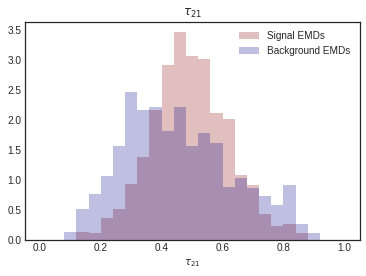

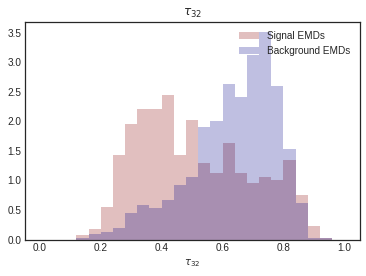

In [30]:
# for j in range(2):
#     plt.hist(emds_old[0,j+1,:] / emds_old[0,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Top Jets", histtype="stepfilled", alpha = 0.25)
#     plt.hist(emds_old[1,j+1,:] / emds_old[1,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Light Jets", histtype="stepfilled", alpha = 0.25)
#     # plt.hist(emds_sinkhorn[0,j+1,:] / emds_sinkhorn[0,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "darkred", label = "Signal Sinkhorn", histtype="stepfilled", alpha = 0.25)
#     # plt.hist(emds_sinkhorn[1,j+1,:] / emds_sinkhorn[1,j,:], bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.25)
#     plt.title(r"$\tau_{%d %d}$" % (j+2, j+1))
#     plt.xlabel(r"$\tau_{%d %d}$" % (j+2, j+1))
#     plt.legend()
#     plt.show()



for j in range(2):
    plt.hist(emds_sinkhorn[0,j+1,1,:] / emds_sinkhorn[0,j,0,:], bins = 25, range=(0.0, 1.000), density = True, color = "darkred", label = "Signal EMDs", histtype="stepfilled", alpha = 0.25)
    plt.hist(emds_sinkhorn[1,j+1,1,:] / emds_sinkhorn[1,j,0,:], bins = 25, range=(0.0, 1.000), density = True, color = "darkblue", label = "Background EMDs", histtype="stepfilled", alpha = 0.25)
    plt.title(r"$\tau_{%d %d}$" % (j+2, j+1))
    plt.xlabel(r"$\tau_{%d %d}$" % (j+2, j+1))
    plt.legend()
    plt.show()

TypeError: alpha must be numeric or None, not <class 'numpy.ndarray'>

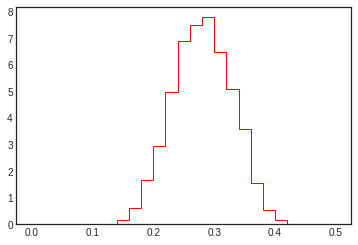

In [33]:
for j in range(3):
    for (e, eps) in enumerate(epsilons):

        # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
        plt.hist(emds_sinkhorn[0,j,e,:] * 0.5 / 0.8, bins = 25, range=(0.0, 0.5), density = True, color = "red", label = "Signal Sinkhorn $\epsilon = $ %.1e" % eps, histtype="step", alpha = (1 - e) / len(epsilons), lw = 3)
    plt.title(r"$\tau_{%d}$" % (j+1))
    plt.xlabel(r"$\tau_{%d}$" % (j+1))
    plt.legend()
    plt.show()


for j in range(3):
    for (e, eps) in enumerate(epsilons):

        # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
        plt.hist(emds_sinkhorn[1,j,e,:] * 0.5 / 0.8, bins = 25, range=(0.0, 0.5), density = True, color = "blue", label = "Background Sinkhorn $\epsilon = $ %.1e" % eps, histtype="step", alpha = (len(epsilons) - e) / len(epsilons), lw = 3)
    plt.title(r"$\tau_{%d}$" % (j+1))
    plt.xlabel(r"$\tau_{%d}$" % (j+1))
    plt.legend()
    plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()


In [ ]:
train(example_signal, _1point, lr = 0.05, early_stopping= 50, epsilon = 0.001)

In [ ]:
# # Compare OLD vs Sinkhorn learned values

# observables = [ 
#         _1subjettiness,
#         _2subjettiness,
#         _3subjettiness,
#   ]
# for (j, obs) in enumerate(observables):

#         params = obs.calculate(example_signal, training_config_dict, plot_filename="temp/test_%i.png" % j)
#         print(params)


# _1point = MixtureModel(shapes = [CoolPoint((-0.01397785,-0.04141136), 1.0)])
# _2point = MixtureModel(shapes = [CoolPoint((-0.01696394,0.04604918), 0.7235), CoolPoint((0.395,0.0535), 0.276)])
# _3point = MixtureModel(shapes = [CoolPoint((-0.01759723, -0.04697237), 0.492), CoolPoint((0.30403854, 0.05707067), 0.2759), CoolPoint((-0.33928187,  0.00147795), 0.2312)])
_3point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.333), CoolPoint((1.0,0.0), 0.333), CoolPoint((0.0,0,0), 0.333)])


# print(train(example_signal, _1point, epochs = 1, lr = 0.00, epsilon = 0.01, init = True))
# print(train(example_signal, _2point, epochs = 1, lr = 0.00, epsilon = 0.01, init = True))
print(train(example_signal, _3point, epochs = 100, lr = 0.05, epsilon = 0.01, init = True))

# print(train(event, _3point, epochs = 500, lr = 0.05, epsilon = 0.01))



0.4701673915333151
0.2213512503576306
0.18433219572600465
Epoch =  0 Loss =  tensor(0.1257, grad_fn=<DivBackward0>) , zs =  [tensor(0.4000, requires_grad=True), tensor(0.3000, requires_grad=True), tensor(0.3000, requires_grad=True)]
Epoch =  1 Loss =  tensor(0.1812, grad_fn=<DivBackward0>) , zs =  [tensor(0.4293, requires_grad=True), tensor(0.2859, requires_grad=True), tensor(0.2848, requires_grad=True)]
Epoch =  2 Loss =  tensor(0.1358, grad_fn=<DivBackward0>) , zs =  [tensor(0.4518, requires_grad=True), tensor(0.2757, requires_grad=True), tensor(0.2725, requires_grad=True)]
Epoch =  3 Loss =  tensor(0.1115, grad_fn=<DivBackward0>) , zs =  [tensor(0.4754, requires_grad=True), tensor(0.2644, requires_grad=True), tensor(0.2603, requires_grad=True)]
Epoch =  4 Loss =  tensor(0.1259, grad_fn=<DivBackward0>) , zs =  [tensor(0.4965, requires_grad=True), tensor(0.2538, requires_grad=True), tensor(0.2498, requires_grad=True)]
Epoch =  5 Loss =  tensor(0.1200, grad_fn=<DivBackward0>) , zs =  [